In [69]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

# colors for plots

In [70]:
sel_cmap = matplotlib.cm.get_cmap('Oranges')
tracker_construction = sel_cmap(1.0)
tracker_proposed = sel_cmap(0.75)

# import data directly from google sheets

In [71]:
#credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek') # present-day version
spreadsheet = gc.open_by_key('1xrFCQ3HIu7CNRg8xsTPV9GczoVfiV8qTQwF674UntdE') # for specific report

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

#pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
pipes_df_orig = gas_pipes.copy()

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [72]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

In [73]:
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df(start='A2')
region_df_africa = region_df_orig.loc[(region_df_orig['AfricaGasTracker']=='Yes')]
region_df_touse = region_df_africa.copy()

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [74]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [75]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [76]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [77]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [78]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# projects by country, by region

In [79]:
#country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_country_df[status] = country_ratios_gas_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


## table 6 - country km (operating)

In [80]:
status = ['Operating']
km_by_country_df_subset = km_by_country_df.loc[(km_by_country_df.index.isin(region_df_touse.Country))]
km_by_country_df_subset = km_by_country_df_subset.sort_values(status, ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(km_by_country_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([km_by_country_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Operating
Country,
Algeria,"13,630.20000"
Libya,"6,243.07000"
Egypt,"3,544.97000"
Nigeria,"3,199.51000"
Tunisia,"1,105.46000"
Rest of Africa,"3,832.01000"
Total,"31,555.22000"


### fig for table 6

## table 7 - country km (in dev)

In [81]:
status = ['Proposed','Construction','Proposed+Construction']
km_by_country_df_subset = km_by_country_df.loc[(km_by_country_df.index.isin(region_df_touse.Country))]
km_by_country_df_subset = km_by_country_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(km_by_country_df_subset[5:].sum()).transpose()
rest_of_africa = rest_of_africa.rename(index={0:'Rest of Africa'})
final_table = pandas.concat([km_by_country_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Proposed,Construction,Proposed+Construction
Country,,,
Mozambique,"4,791.70000",0.00000,"4,791.70000"
South Africa,"4,352.21000",0.00000,"4,352.21000"
Nigeria,"2,669.51000","1,427.00000","4,096.51000"
Niger,"1,359.82000",0.00000,"1,359.82000"
Algeria,"1,294.68000",0.00000,"1,294.68000"
Rest of Africa,"7,592.30000",445.00000,"8,037.30000"
Total,"22,060.22000","1,872.00000","23,932.22000"


### fig for table 7 (NOW Fig 6)

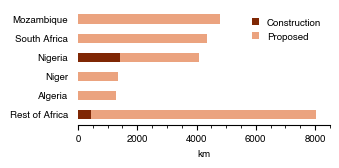

In [82]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Proposed+Construction').drop('Total')
rest_df = use_this_df.loc[['Rest of Africa']]
use_this_df = pandas.concat([rest_df, use_this_df.drop('Rest of Africa')])
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction'],
       color=tracker_construction, label='Construction', height=set_width)
ax.barh(range(use_this_df.index.size), use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction'], height=set_width, alpha=0.5)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('km', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 8500)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-pipeline-km-in-dev-fig6.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-pipeline-km-in-dev-fig6.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-pipeline-km-in-dev-fig6.svg',
          bbox_inches='tight', 
          transparent=True)

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

In [83]:
outliers_projectids = ['P2509','P0173','P1297', 'P4033', 'P0174','P3188','P2551', 'P4069', 'P0331', 'P1382','P0477']
# for gas...

In [84]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Gas') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0) &
                                    (country_ratios_df['CostUSDPerKm']<10e6) &
                                    ~(country_ratios_df['ProjectID'].isin(outliers_projectids))
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [85]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2411610.589168704

### create regional costs tables

In [86]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Region']==region]
    pipes_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region,'NumberOfCosts'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    pipes_costs_region_df.loc[region,'NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


### table for methodology with regional cost info

In [87]:
pipes_costs_region_df

,CostUSDPerKm,NumberOfCosts,NumberOfLengths
Australia and New Zealand,"1,306,846.06900",10,10
East Asia,"1,445,626.52582",54,54
Eurasia,"2,933,394.82204",41,41
Europe,"2,476,551.38174",111,111
Latin America and the Caribbean,"2,868,906.17250",23,23
Middle East and North Africa,"2,223,702.07848",35,35
North America,"3,469,279.81570",133,133
SE Asia,"2,366,359.15000",8,8
South Asia,"1,663,439.59400",17,17
Sub-Saharan Africa,"3,928,708.95412",5,5


### calculate country-level costs using regional means

In [88]:
#country_list_for_costs = sorted(list(set(country_ratios_with_length_and_cost_df['Country'])))
pipes_costs_country_df = pandas.DataFrame(0, index=country_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for country in country_list:#_for_costs:

    country_ratios_specific_country_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Country']==country]
    pipes_costs_country_df.loc[country,'CostUSDPerKm'] = country_ratios_specific_country_df['CostUSDPerKm'].mean()
    pipes_costs_country_df.loc[country,'NumberOfCosts'] = list(set(country_ratios_specific_country_df['ProjectID'])).__len__()
    pipes_costs_country_df.loc[country,'NumberOfLengths'] = list(set(country_ratios_specific_country_df['ProjectID'])).__len__()
    

# tables etc.

## table for regional totals

In [89]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62132/997741405.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_region_df = km_by_region_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,"31,379.31000","26,378.73000","57,758.04000","2,067.66000","1,364.51000","92,288.71000",0.00000,0.00000,41.00000
Eurasia,"18,370.35000","5,153.09000","23,523.44000",272.69000,"5,756.89000","129,176.25000",0.00000,"3,298.31000","1,783.24000"
South Asia,"4,222.57000","17,113.79000","21,336.36000","6,344.41000","6,141.07000","29,701.06000",0.00000,0.00000,35.00000
Sub-Saharan Africa,"18,355.36000","1,582.00000","19,937.36000","1,626.16000",228.96000,"7,031.52000",0.00000,0.00000,0.00000
Europe,"17,145.97000","2,652.19000","19,798.16000","4,707.47000","15,267.44000","121,668.45000",0.00000,"4,735.18000",823.06000
Latin America and the Caribbean,"12,772.03000","1,304.00000","14,076.03000","2,187.28000","1,301.39000","39,254.35000",0.00000,224.00000,0.00000
Middle East and North Africa,"6,211.81000","7,773.20000","13,985.01000","5,964.34000","4,146.27000","49,700.91000",0.00000,"1,107.39000",39.28000
North America,"10,347.34000","3,087.20000","13,434.54000","10,919.39000","13,277.01000","421,015.95000",331.00000,0.00000,0.00000
Australia and New Zealand,"12,590.05000",580.00000,"13,170.05000",334.28000,"6,194.68000","30,991.82000",0.00000,0.00000,0.00000
SE Asia,"9,222.66000",984.30000,"10,206.96000","2,801.34000","1,423.82000","16,880.81000",0.00000,0.00000,0.00000


## table for km by country

In [90]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

#km_by_country_df.to_excel('GGIT-km-by-country.xlsx')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62132/3175616226.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_country_df = km_by_country_df.append(total)


# table for stranded asset calculations

## country-level capex estimates

In [91]:
country_ratios_gas_df = country_ratios_df.loc[country_ratios_df['Fuel']=='Gas']
country_ratios_gas_df = country_ratios_gas_df.reset_index(drop=True)
country_ratios_gas_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_gas_df.iterrows():
    # only add the km that DON'T have cost data
    #if numpy.isnan(row.CostUSDPerKm):
    #    break
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.MergedKmByCountry
    #print(row.PipelineName)
    country_ratios_gas_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKm.isna())&
                      (~country_ratios_gas_df.CostUSD.isna()),'CostUSDEstimate'] = \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKm.isna())&
                      (~country_ratios_gas_df.CostUSD.isna()),'LengthKnownKmByCountry'] * \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKm.isna())&
                      (~country_ratios_gas_df.CostUSD.isna()),'CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_gas_df.loc[(country_ratios_gas_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

In [92]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df.loc[country_ratios_gas_df.Status==status]
    capex_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df.loc[country_ratios_gas_df.Status==status]
    capex_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [93]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [94]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [95]:
capex_by_country_df.loc[(capex_by_country_df.index.isin(region_df_touse.Country))]

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Mozambique,18.82519,0.00000,18.82519,0.17679,0.00000,2.57519,0.00000,0.00000,0.00000
South Africa,17.09857,0.00000,17.09857,0.00000,0.00000,3.57324,0.00000,0.00000,0.00000
Nigeria,9.33915,3.38895,12.72810,0.00000,0.69522,12.56994,0.00000,0.00000,0.00000
Morocco,4.45881,0.00000,4.45881,0.00000,0.00000,0.00000,0.00000,1.24085,0.00000
Niger,4.28238,0.00000,4.28238,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Algeria,4.07724,0.00000,4.07724,0.46373,0.69824,25.08661,0.00000,1.22166,0.00000
Ethiopia,3.60537,0.00000,3.60537,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Western Sahara,3.49072,0.00000,3.49072,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Liberia,2.87412,0.00000,2.87412,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Côte d'Ivoire,2.19708,0.00000,2.19708,0.54479,0.00000,0.31430,0.00000,0.00000,0.00000


# table 8 - capex

In [96]:
status = ['Proposed','Construction','Proposed+Construction']
capex_by_country_df_subset = capex_by_country_df.loc[(capex_by_country_df.index.isin(region_df_touse.Country))]
capex_by_country_df_subset = capex_by_country_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(capex_by_country_df_subset[5:].sum()).transpose()
rest_of_africa = rest_of_africa.rename(index={0:'Rest of Africa'})
final_table = pandas.concat([capex_by_country_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Proposed,Construction,Proposed+Construction
Country,,,
Mozambique,18.82519,0.00000,18.82519
South Africa,17.09857,0.00000,17.09857
Nigeria,9.33915,3.38895,12.72810
Morocco,4.45881,0.00000,4.45881
Niger,4.28238,0.00000,4.28238
Rest of Africa,30.49484,0.95039,31.44523
Total,84.49894,4.33934,88.83827


## figure for table 8 (NOW Fig 7)

In [36]:
costs_con = tracker_construction
costs_prop = tracker_proposed

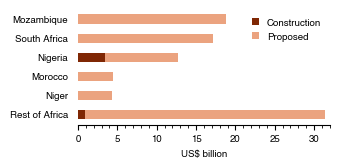

In [97]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Proposed+Construction').drop('Total')
rest_df = use_this_df.loc[['Rest of Africa']]
use_this_df = pandas.concat([rest_df, use_this_df.drop('Rest of Africa')])
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction'],
       color=costs_con, label='Construction', height=set_width)
ax.barh(range(use_this_df.index.size), use_this_df['Proposed'],
       color=costs_prop, label='Proposed',
      left=use_this_df['Construction'], height=set_width, alpha=0.5)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('US$ billion', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 32)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-pipeline-km-capex-fig7.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-pipeline-km-capex-fig7.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-pipeline-km-capex-fig7.svg',
          bbox_inches='tight', 
          transparent=True)

# parent analysis

In [98]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['Proposed','Construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

In [99]:
owner_parent_calculations_df.loc[owner_parent_calculations_df.ProjectID=='P2250']

,Parent,ProjectID,FractionOwnership,ParentHQCountry,PipelineCountry,Status,MergedKmByCountry,MergedKmByPipeline,CapacityBOEd,KmOwnershipByCountry
0,Empresa Nacional de Hidrocarbonetos de Mozambique,P2250,0.50000,Unknown,Mozambique,Proposed,"2,600.00000","2,600.00000",NaN,"1,300.00000"
0,Gigajoule International,P2250,0.50000,Unknown,Mozambique,Proposed,"2,600.00000","2,600.00000",NaN,"1,300.00000"


In [100]:
parent_country_km_df = \
owner_parent_calculations_df.loc[(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

In [101]:
parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

In [102]:
parent_country_km_df_table['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
#parent_country_km_df_table['Operating'] = parent_country_km_df.loc[parent_country_km_df.Status=='Operating'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
#parent_country_km_df_table['Countries'] = pandas.DataFrame(owner_parent_calculations_df.groupby('Parent')['PipelineCountry'].transform(lambda x: ', '.join(x.unique()))).set_index(owner_parent_calculations_df.Parent)


## pipelines owner table for report

In [103]:
pandas.options.display.max_colwidth = 500
#pandas.DataFrame(owner_parent_calculations_df.groupby('Parent')['PipelineCountry'].transform(lambda x: ', '.join(x.unique()))).set_index(owner_parent_calculations_df.Parent)
#owner_parent_calculations_df.groupby(['Parent']).agg({'PipelineCountry': [pandas.Series.unique,', '.join]})
country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (Proposed + Construction)'] = parent_country_km_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]
                 

,Pipeline Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs
Nigerian National Petroleum Corporation,"Nigeria, Niger, Algeria, Liberia, Senegal, Guinea-Bissau, Mauritania, Côte d'Ivoire, Western Sahara, Sierra Leone, Morocco, Guinea, Spain, The Gambia, Ghana, Joint regime area (Senegal/Guinea Bissau)",Nigeria,"4,708.46833","1,427.00000","6,135.46833","P0460, P0463, P0488, P1313, P4185"
Transnet,"Namibia, South Africa",South Africa,"3,949.19000",,"3,949.19000","P2254, P2469, P2470, P2471, P2472, P2473, P2474, P3337, P3338, P3339"
Moroccan National Board of Hydrocarbons and Mines,"Liberia, Senegal, Guinea-Bissau, Mauritania, Côte d'Ivoire, Western Sahara, Sierra Leone, Morocco, Guinea, Spain, The Gambia, Ghana, Joint regime area (Senegal/Guinea Bissau)",Morocco,"2,646.46500",,"2,646.46500",P0463
Empresa Nacional de Hidrocarbonetos de Mozambique,"South Africa, Mozambique",Unknown,"1,950.00000",,"1,950.00000","P2249, P2250"
"Niger Ministry of Petroleum, Energy and Renewable Energies","Nigeria, Niger, Algeria",Niger,"1,376.00333",,"1,376.00333",P0460
Sonatrach,"Nigeria, Niger, Algeria",Algeria,"1,376.00333",,"1,376.00333",P0460
Gigajoule International,Mozambique,Unknown,"1,300.00000",,"1,300.00000",P2250
"GCL-Poly Natural Gas Group Holdings Co., Ltd. 保利協鑫天然氣集團控股有限公司","Djibouti, Ethiopia",Unknown,767.00000,,767.00000,P2196
Profin Consulting,"South Africa, Mozambique",Unknown,650.00000,,650.00000,P2249
Progas Investment Group,"South Africa, Mozambique",Unknown,650.00000,,650.00000,P2249


In [104]:
parent_country_km_df.groupby(['Parent','PipelineCountry','ParentHQCountry','Status']).sum('KmOwnershipByCountry')

FractionOwnership  \
Parent                               PipelineCountry ParentHQCountry Status                            
Axxela                               Nigeria         Unknown         Proposed                1.00000   
China National Petroleum Corporation Mozambique      China           Proposed                0.25000   
                                     South Africa    China           Proposed                0.25000   
Delek Group                          Egypt           Unknown         Proposed                0.30000   
Egyptian Natural Gas Holding Company Egypt           Egypt           Construction            1.00000   
...                                                                                              ...   
Sonatrach                            Niger           Algeria         Proposed                0.33333   
                                     Nigeria         Algeria         Proposed                0.33333   
Transnet                             Namibia         South Africa    Proposed                1.00000   
                                     South Africa    South Africa    Proposed               10.00000   
Unknown                              Morocco         Unknown         Proposed                1.00000   

                                                                                   MergedKmByCountry  \
Parent                               PipelineCountry ParentHQCountry Status                            
Axxela                               Nigeria         Unknown         Proposed              510.00000   
China National Petroleum Corporation Mozambique      China           Proposed            2,191.70000   
                                     South Africa    China           Proposed              408.30000   
Delek Group                          Egypt           Unknown         Proposed              191.77000   
Egyptian Natural Gas Holding Company Egypt           Egypt           Construction          170.00000   
...                                                                                              ...   
Sonatrach                            Niger           Algeria         Proposed            1,359.82000   
                                     Nigeria         Algeria         Proposed            1,473.51000   
Transnet                             Namibia         South Africa    Proposed                5.28000   
                                     South Africa    South Africa    Proposed            3,943.91000   
Unknown                              Morocco         Unknown         Proposed              120.00000   

                                                                                   MergedKmByPipeline  \
Parent                               PipelineCountry ParentHQCountry Status                             
Axxela                               Nigeria         Unknown         Proposed               510.00000   
China National Petroleum Corporation Mozambique      China           Proposed             2,600.00000   
                                     South Africa    China           Proposed             2,600.00000   
Delek Group                          Egypt           Unknown         Proposed               214.58000   
Egyptian Natural Gas Holding Company Egypt           Egypt           Construction           170.00000   
...                                                                                               ...   
Sonatrach                            Niger           Algeria         Proposed             4,128.00000   
                                     Nigeria         Algeria         Proposed             4,128.00000   
Transnet                             Namibia         South Africa    Proposed               289.17000   
                                     South Africa    South Africa    Proposed             3,949.19000   
Unknown                              Morocco         Unknown         Proposed               120.00000   

           

## answering David's question about where the pipelines are going

In [105]:
parent_country_km_df_table2 = pandas.DataFrame(index=parent_country_km_df.PipelineCountry.unique().tolist(),
                                             columns=['Owner Headquarters Country','Owners',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

parent_country_km_df_table2['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('PipelineCountry').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table2['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('PipelineCountry').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]




In [112]:
pandas.options.display.max_colwidth = 500
#pandas.DataFrame(owner_parent_calculations_df.groupby('Parent')['PipelineCountry'].transform(lambda x: ', '.join(x.unique()))).set_index(owner_parent_calculations_df.Parent)
#owner_parent_calculations_df.groupby(['Parent']).agg({'PipelineCountry': [pandas.Series.unique,', '.join]})
#country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['PipelineCountry']).PipelineCountry.agg(lambda x: '; '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['PipelineCountry']).ProjectID.agg(lambda x: '; '.join(x.unique())))
owner_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['PipelineCountry']).Parent.agg(lambda x: '; '.join(x.unique())))
#parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table2['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table2['Owners'] = owner_agg_df.Parent
#parent_country_km_df_table2['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table2['In Development (Proposed + Construction)'] = parent_country_km_df_table2[['Proposed','Construction']].sum(axis=1, min_count=0)

parent_country_km_df_table2.loc[~parent_country_km_df_table2.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:5]

,Owner Headquarters Country,Owners,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs
Mozambique,,China National Petroleum Corporation; Empresa Nacional de Hidrocarbonetos de Mozambique; Profin Consulting; Progas Investment Group; Gigajoule International,"4,791.70000",,"4,791.70000",P2249; P2250
South Africa,,China National Petroleum Corporation; Empresa Nacional de Hidrocarbonetos de Mozambique; Profin Consulting; Progas Investment Group; Transnet,"4,352.21000",,"4,352.21000",P2249; P2254; P2469; P2470; P2471; P2472; P2473; P2474; P3337; P3338; P3339
Nigeria,,"Niger Ministry of Petroleum, Energy and Renewable Energies; Nigerian National Petroleum Corporation; Sonatrach; Axxela","2,669.51000","1,427.00000","4,096.51000",P0460; P0488; P1313; P3340; P4185
Niger,,"Niger Ministry of Petroleum, Energy and Renewable Energies; Nigerian National Petroleum Corporation; Sonatrach","1,359.82000",,"1,359.82000",P0460
Algeria,,"Niger Ministry of Petroleum, Energy and Renewable Energies; Nigerian National Petroleum Corporation; Sonatrach","1,294.68000",,"1,294.68000",P0460


In [119]:
projectids_to_look_at = parent_country_km_df_table2.loc[~parent_country_km_df_table2.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:5][['ProjectIDs']]

In [124]:
projectid_list = list(set('; '.join(projectids_to_look_at.ProjectIDs).split('; ')))

In [128]:
pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(projectid_list)][['ProjectID','PipelineName','SegmentName','Wiki','LengthMergedKm']].set_index('ProjectID')

,PipelineName,SegmentName,Wiki,LengthMergedKm
ProjectID,,,,
P0460,Trans-Sahara Gas Pipeline,,https://www.gem.wiki/Trans-Sahara_Gas_Pipeline,"4,128.00000"
P0488,Obiafu-Obrikom-Oben Gas Pipeline,,https://www.gem.wiki/Obiafu-Obrikom-Oben_Gas_Pipeline,127.00000
P1313,Trans Nigeria Gas Pipeline,Phase 1: Ajaokuta–Kaduna–Kano Pipeline (AKK Pipeline),https://www.gem.wiki/Trans_Nigeria_Gas_Pipeline,"1,300.00000"
P2249,African Renaissance Gas Pipeline,,https://www.gem.wiki/African_Renaissance_Gas_Pipeline,"2,600.00000"
P2250,GasNosu North–South Gas Pipeline,,https://www.gem.wiki/GasNosu_North%E2%80%93South_Gas_Pipeline,"2,600.00000"
P2254,Phased Gas Pipeline Network,Abraham Villiers Bay–Oranjemund,https://gem.wiki/Phased_Gas_Pipeline_Network,289.17000
P2469,Phased Gas Pipeline Network,Coega–Richards Bay Gas Pipeline,https://gem.wiki/Phased_Gas_Pipeline_Network,820.46000
P2470,Phased Gas Pipeline Network,Mossel Bay–Coega Gas Pipeline,https://gem.wiki/Phased_Gas_Pipeline_Network,332.44000
P2471,Phased Gas Pipeline Network,Richards Bay–Gauteng Gas Pipeline,https://gem.wiki/Phased_Gas_Pipeline_Network,514.62000


## print out country-level stranded assets for Christine Juta's report

In [107]:
country_list_from_region_defs = sorted(region_df_touse.Country.to_list())

In [108]:
country_list_to_use = [ \
"Algeria",
"Angola",
"Benin",
"Botswana",
"Burkina Faso",
"Burundi",
"Cabo Verde",
"Cameroon",
"Central African Republic",
"Chad",
"Comoros",
"Republic of the Congo",
"DR Congo",
"Côte d'Ivoire",
"Djibouti",
"Egypt",
"Equatorial Guinea",
"Eritrea",
"Eswatini",
"Ethiopia",
"Gabon",
"The Gambia",
"Ghana",
"Guinea",
"Guinea-Bissau",
"Kenya",
"Lesotho",
"Liberia",
"Libya",
"Madagascar",
"Malawi",
"Mali",
"Mauritania",
"Mauritius",
"Morocco",
"Mozambique",
"Namibia",
"Niger",
"Nigeria",
"Rwanda",
"Sao Tome and Principe",
"Senegal",
"Seychelles",
"Sierra Leone",
"Somalia",
"South Africa",
"South Sudan",
"Sudan",
"Tanzania",
"Togo",
"Tunisia",
"Uganda",
"Western Sahara",
"Zambia",
"Zimbabwe" ]

change_these = {
    'Republic of the Congo':'Congo',
    'The Gambia':'Gambia'
}

In [110]:
pandas.options.display.float_format = '{:,.5f}'.format
capex_by_country_df.loc[capex_by_country_df.index.isin(country_list_to_use),['Proposed','Construction']].reindex(country_list_to_use).replace(numpy.nan,0).rename(index=change_these)

,Proposed,Construction
Algeria,4.07724,0.00000
Angola,0.00000,0.00000
Benin,0.00000,0.00000
Botswana,0.00000,0.00000
Burkina Faso,0.00000,0.00000
Burundi,0.00000,0.00000
Cabo Verde,0.00000,0.00000
Cameroon,0.00000,0.00000
Central African Republic,0.00000,0.00000
Chad,0.00000,0.00000


In [111]:
km_by_country_df.loc[km_by_country_df.index.isin(country_list_to_use),['Proposed','Construction','Operating']].reindex(country_list_to_use).replace(numpy.nan,0).rename(index=change_these)

,Proposed,Construction,Operating
Algeria,"1,294.68000",0.00000,"13,630.20000"
Angola,0.00000,0.00000,383.02000
Benin,0.00000,0.00000,128.50000
Botswana,0.00000,0.00000,0.00000
Burkina Faso,0.00000,0.00000,0.00000
Burundi,0.00000,0.00000,0.00000
Cabo Verde,0.00000,0.00000,0.00000
Cameroon,0.00000,0.00000,0.00000
Central African Republic,0.00000,0.00000,0.00000
Chad,0.00000,0.00000,0.00000


In [50]:
country_ratios_df.loc[country_ratios_df.Country=='Guinea'].MergedKmByCountry.sum()

319.27